In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras
%matplotlib inline
sns.set()
print(os.listdir("../input"))
# Setting seed for reproducability
np.random.seed(1234)  
PYTHONHASHSEED = 0

In [2]:
target_var = ['Target_Remaining_Useful_Life']
index_columns_names =  ["UnitNumber","Cycle"]
op_settings_columns = ["Op_Setting_"+str(i) for i in range(1,4)]
sensor_columns =["Sensor_"+str(i) for i in range(1,22)]
column_names = index_columns_names + op_settings_columns + sensor_columns
print(column_names)

['UnitNumber', 'Cycle', 'Op_Setting_1', 'Op_Setting_2', 'Op_Setting_3', 'Sensor_1', 'Sensor_2', 'Sensor_3', 'Sensor_4', 'Sensor_5', 'Sensor_6', 'Sensor_7', 'Sensor_8', 'Sensor_9', 'Sensor_10', 'Sensor_11', 'Sensor_12', 'Sensor_13', 'Sensor_14', 'Sensor_15', 'Sensor_16', 'Sensor_17', 'Sensor_18', 'Sensor_19', 'Sensor_20', 'Sensor_21']


In [3]:
train= pd.read_csv('data/train_FD001.txt', sep=" ", header=None)
test = pd.read_csv('data/test_FD001.txt', sep=" ", header=None)
print("train shape: ", train.shape, "test shape: ", test.shape)
# drop pesky NULL columns
train.drop(train.columns[[26, 27]], axis=1, inplace=True)
test.drop(test.columns[[26, 27]], axis=1, inplace=True)
# name columns
train.columns = [column_names]
test.columns = [column_names]
train[train['UnitNumber'] == 1].head(5)
test[test['UnitNumber'] == 1].head(5)

train shape:  (20631, 28) test shape:  (13096, 28)


,UnitNumber,Cycle,Op_Setting_1,Op_Setting_2,Op_Setting_3,Sensor_1,Sensor_2,Sensor_3,Sensor_4,Sensor_5,...,Sensor_12,Sensor_13,Sensor_14,Sensor_15,Sensor_16,Sensor_17,Sensor_18,Sensor_19,Sensor_20,Sensor_21
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130


In [4]:
max_cycle = train.groupby('UnitNumber')['Cycle'].max().reset_index()
max_cycle.columns = ['UnitNumber', 'MaxOfCycle']
# merge the max cycle back into the original frame
train_merged = train.merge(max_cycle, left_on='UnitNumber', right_on='UnitNumber', how='inner')
# calculate RUL for each row
Target_Remaining_Useful_Life = train_merged["MaxOfCycle"] - train_merged["Cycle"]
train_with_target = train_merged["Target_Remaining_Useful_Life"] = Target_Remaining_Useful_Life
# remove unnecessary column
train_with_target = train_merged.drop("MaxOfCycle", axis=1)
train_with_target[train_with_target['UnitNumber'] == 1].head(5)

,UnitNumber,Cycle,Op_Setting_1,Op_Setting_2,Op_Setting_3,Sensor_1,Sensor_2,Sensor_3,Sensor_4,Sensor_5,...,Sensor_13,Sensor_14,Sensor_15,Sensor_16,Sensor_17,Sensor_18,Sensor_19,Sensor_20,Sensor_21,Target_Remaining_Useful_Life
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


In [5]:
print(train_with_target.shape)
leakage_to_drop = ['UnitNumber', 'Cycle', 'Op_Setting_1', 'Op_Setting_2', 'Op_Setting_3']  
train_no_leakage = train_with_target.drop(leakage_to_drop, axis = 1)
print(train_no_leakage.shape)
# set up features and target variable 
y = train_no_leakage['Target_Remaining_Useful_Life']
X = train_no_leakage.drop(['Target_Remaining_Useful_Life'], axis = 1)

(20631, 27)
(20631, 22)


In [10]:
print(np.shape(X))
X.head()

(20631, 21)


,Sensor_1,Sensor_2,Sensor_3,Sensor_4,Sensor_5,Sensor_6,Sensor_7,Sensor_8,Sensor_9,Sensor_10,...,Sensor_12,Sensor_13,Sensor_14,Sensor_15,Sensor_16,Sensor_17,Sensor_18,Sensor_19,Sensor_20,Sensor_21
0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [15]:
from sklearn import ensemble
rf = ensemble.RandomForestRegressor()
single_rf = ensemble.RandomForestRegressor(n_estimators = 200, max_depth = 15)
single_rf.fit(X, y)
y_pred = single_rf.predict(X)
print("complete")

complete


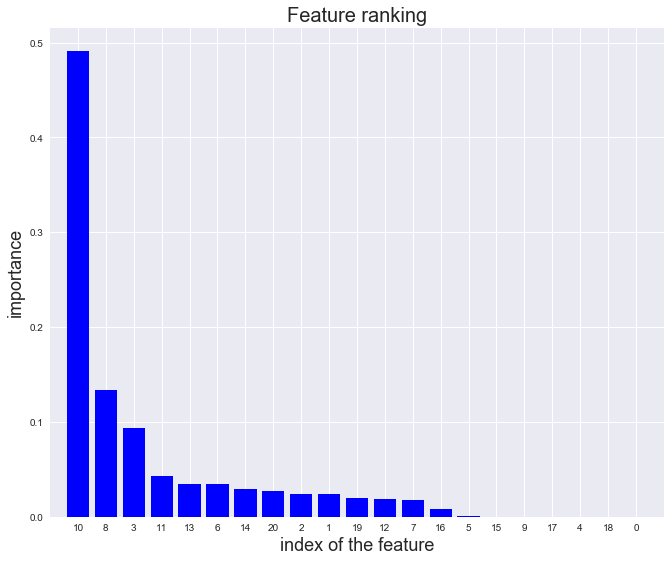

Sensor_11    0.491205
Sensor_9     0.134102
Sensor_4     0.093463
Sensor_12    0.042893
Sensor_14    0.034412
Sensor_7     0.034160
Sensor_15    0.029577
Sensor_21    0.027591
Sensor_3     0.024412
Sensor_2     0.023597
dtype: float64


In [16]:
import matplotlib.pyplot as plt
importances = single_rf.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X.columns    
f, ax = plt.subplots(figsize=(11, 9))
plt.title("Feature ranking", fontsize = 20)
plt.bar(range(X.shape[1]), importances[indices], color="b", align="center")
plt.xticks(range(X.shape[1]), indices) #feature_names, rotation='vertical')
plt.xlim([-1, X.shape[1]])
plt.ylabel("importance", fontsize = 18)
plt.xlabel("index of the feature", fontsize = 18)
plt.show()
# list feature importance
important_features = pd.Series(data=single_rf.feature_importances_,index=X.columns)
important_features.sort_values(ascending=False,inplace=True)
print(important_features.head(10))

In [17]:
#把不重要的几个feature drop了
print(train_no_leakage.shape)
vars_to_drop = ["Sensor_"+str(i) for i in [5, 15, 9, 17, 4, 18]]
train_final = train_no_leakage.drop(vars_to_drop, axis = 1)
print(train_final.shape)

(20631, 22)
(20631, 16)


In [38]:
# identify categorical and numeric fields
# 不知道这有什么用
from sklearn import preprocessing
categorical = train_final.select_dtypes(include=['object'])
numeric = train_final.select_dtypes(exclude=['object'])
print(categorical.columns.values)
# create dummy variables (if any categorical fields)
for name, values in categorical.items():
    print(name)
    dummies = pd.get_dummies(values.str.strip(), prefix = name, dummy_na=True)
    numeric = pd.concat([numeric, dummies], axis=1)
# imputation (if any NULL values)
for name in numeric:
    print(name)
    if pd.isnull(numeric[name]).sum() > 0:
        numeric["%s_mi" % (name)] = pd.isnull(numeric[name])
        median = numeric[name].median()
        numeric[name] = numeric[name].apply(lambda x: median if pd.isnull(x) else x)
y = numeric['Target_Remaining_Useful_Life']
X = numeric.drop(['Target_Remaining_Useful_Life'], axis = 1)

[]
Sensor_1
Sensor_2
Sensor_3
Sensor_6
Sensor_7
Sensor_8
Sensor_10
Sensor_11
Sensor_12
Sensor_13
Sensor_14
Sensor_16
Sensor_19
Sensor_20
Sensor_21
Target_Remaining_Useful_Life


In [24]:
np.shape(X_train)

(16504, 15)

In [25]:
import numpy as np
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)
# choose the model
from sklearn.ensemble import RandomForestRegressor
rf = ensemble.RandomForestRegressor()
# set up 5-fold cross-validation
from sklearn import model_selection
cv = model_selection.KFold(5)
# pipeline standardization and model
from sklearn.pipeline import Pipeline
pipeline = Pipeline(steps=[('standardize', preprocessing.StandardScaler())
                           , ('model', rf) ])
# tune the model
my_min_samples_leaf = [2, 10, 25, 50, 100]
my_max_depth = [7, 8, 9, 10, 11, 12]
# run the model using gridsearch, select the model with best search
from sklearn.model_selection import GridSearchCV
optimized_rf = GridSearchCV(estimator=pipeline
                            , cv=cv
                            , param_grid =dict(model__min_samples_leaf = my_min_samples_leaf, model__max_depth = my_max_depth)
                            , scoring = 'neg_mean_squared_error'
                            , verbose = 1
                            , n_jobs = -1
                           )
optimized_rf.fit(X_train, y_train)
# show the best model estimators
print(optimized_rf.best_estimator_)
# evaluate metrics on holdout
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
y_pred = optimized_rf.predict(X_test)
print("Random Forest Mean Squared Error: ", mean_squared_error(y_test, y_pred))
print("Random Forest Mean Absolute Error: ", mean_absolute_error(y_test, y_pred))
print("Random Forest r-squared: ", r2_score(y_test, y_pred))

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   16.6s finished


Pipeline(memory=None,
     steps=[('standardize', StandardScaler(copy=True, with_mean=True, with_std=True)), ('model', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=9,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=25, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False))])
Random Forest Mean Squared Error:  1799.5276243279602
Random Forest Mean Absolute Error:  30.25600504941975
Random Forest r-squared:  0.6192426376800281


{'cv': KFold(n_splits=5, random_state=None, shuffle=False),
 'error_score': 'raise',
 'estimator': Pipeline(memory=None,
      steps=[('standardize', StandardScaler(copy=True, with_mean=True, with_std=True)), ('model', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
            max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0, warm_start=False))]),
 'estimator__memory': None,
 'estimator__model': RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
            max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, 

In [26]:
optimized_rf.best_estimator_

Pipeline(memory=None,
     steps=[('standardize', StandardScaler(copy=True, with_mean=True, with_std=True)), ('model', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=9,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=25, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False))])

In [ ]:
# 拿全部的feature测一下

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)
# choose the model
from sklearn.ensemble import RandomForestRegressor
rf = ensemble.RandomForestRegressor()
# set up 5-fold cross-validation
from sklearn import model_selection
cv = model_selection.KFold(5)
# pipeline standardization and model
from sklearn.pipeline import Pipeline
pipeline = Pipeline(steps=[('standardize', preprocessing.StandardScaler())
                           , ('model', rf) ])
# tune the model
my_min_samples_leaf = [2, 10, 25, 50, 100]
my_max_depth = [7, 8, 9, 10, 11, 12]
# run the model using gridsearch, select the model with best search
from sklearn.model_selection import GridSearchCV
optimized_rf = GridSearchCV(estimator=pipeline
                            , cv=cv
                            , param_grid =dict(model__min_samples_leaf = my_min_samples_leaf, model__max_depth = my_max_depth)
                            , scoring = 'neg_mean_squared_error'
                            , verbose = 1
                            , n_jobs = -1
                           )
optimized_rf.fit(X_train, y_train)
# show the best model estimators
print(optimized_rf.best_estimator_)
# evaluate metrics on holdout
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
y_pred = optimized_rf.predict(X_test)
print("Random Forest Mean Squared Error: ", mean_squared_error(y_test, y_pred))
print("Random Forest Mean Absolute Error: ", mean_absolute_error(y_test, y_pred))
print("Random Forest r-squared: ", r2_score(y_test, y_pred))

In [28]:
rf = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=9,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=25, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
rf.fit(X_train, y_train)
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
y_pred = rf.predict(X_test)
print("Random Forest Mean Squared Error: ", mean_squared_error(y_test, y_pred))
print("Random Forest Mean Absolute Error: ", mean_absolute_error(y_test, y_pred))
print("Random Forest r-squared: ", r2_score(y_test, y_pred))

Random Forest Mean Squared Error:  1801.5603140772732
Random Forest Mean Absolute Error:  30.270853383794073
Random Forest r-squared:  0.6188125461510623


In [29]:
X_train

,Sensor_1,Sensor_2,Sensor_3,Sensor_6,Sensor_7,Sensor_8,Sensor_10,Sensor_11,Sensor_12,Sensor_13,Sensor_14,Sensor_16,Sensor_19,Sensor_20,Sensor_21
6240,518.67,642.73,1587.11,21.61,553.76,2388.07,1.3,47.47,521.29,2388.17,8135.19,0.03,100.0,38.92,23.2388
3161,518.67,642.45,1591.03,21.61,552.76,2388.10,1.3,47.51,520.71,2388.08,8140.24,0.03,100.0,38.78,23.2820
1887,518.67,642.89,1595.01,21.61,552.79,2388.02,1.3,47.45,521.28,2388.05,8207.79,0.03,100.0,38.79,23.2424
151,518.67,642.67,1598.60,21.61,552.62,2388.18,1.3,47.72,520.39,2388.19,8119.00,0.03,100.0,38.77,23.2369
8768,518.67,642.88,1594.96,21.61,553.03,2388.07,1.3,47.59,520.66,2388.06,8160.04,0.03,100.0,38.84,23.3358
5906,518.67,642.53,1582.19,21.61,554.32,2388.05,1.3,47.25,522.47,2388.02,8145.19,0.03,100.0,38.95,23.3742
6091,518.67,642.24,1588.38,21.60,553.83,2388.03,1.3,47.14,521.85,2388.04,8143.61,0.03,100.0,39.02,23.2901
19955,518.67,642.80,1586.30,21.61,554.53,2388.02,1.3,47.26,521.63,2388.09,8132.53,0.03,100.0,38.88,23.3220
2586,518.67,642.23,1588.43,21.61,553.26,2388.10,1.3,47.58,521.82,2388.10,8137.55,0.03,100.0,38.92,23.3163
3066,518.67,643.29,1589.52,21.61,553.14,2388.24,1.3,47.81,521.11,2388.20,8124.81,0.03,100.0,38.75,23.2851


In [42]:
y[0:10]

0    191
1    190
2    189
3    188
4    187
5    186
6    185
7    184
8    183
9    182
Name: Target_Remaining_Useful_Life, dtype: int64

In [49]:
XX

,Sensor_3,Sensor_6,Sensor_7,Sensor_8,Sensor_10,Sensor_11
0,1589.70,21.61,554.36,2388.06,1.3,47.47
1,1591.82,21.61,553.75,2388.04,1.3,47.49
2,1587.99,21.61,554.26,2388.08,1.3,47.27
3,1582.79,21.61,554.45,2388.11,1.3,47.13
4,1582.85,21.61,554.00,2388.06,1.3,47.28
5,1584.47,21.61,554.67,2388.02,1.3,47.16
6,1592.32,21.61,554.34,2388.02,1.3,47.36
7,1582.96,21.61,553.85,2388.00,1.3,47.24
8,1590.98,21.61,553.69,2388.05,1.3,47.29
9,1591.24,21.61,553.59,2388.05,1.3,47.03


In [52]:
from sklearn.model_selection import TimeSeriesSplit
XX = X.iloc[0:11,2:8]
yy = X.iloc[0:11,9:10]
tscv = TimeSeriesSplit(n_splits=3)
print(tscv)  
TimeSeriesSplit(max_train_size=None, n_splits=3)
for train_index, test_index in tscv.split(XX):
    print("TRAIN:", train_index, "TEST:", test_index)
#     X_train, X_test = XX[train_index], XX[test_index]
#     y_train, y_test = yy[train_index], yy[test_index]

TimeSeriesSplit(max_train_size=None, n_splits=3)
TRAIN: [0 1 2 3 4] TEST: [5 6]
TRAIN: [0 1 2 3 4 5 6] TEST: [7 8]
TRAIN: [0 1 2 3 4 5 6 7 8] TEST: [ 9 10]
